In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [12]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#     -O /tmp/daily-min-temperatures.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


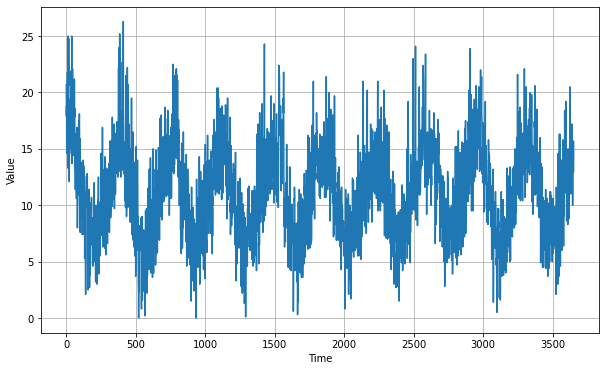

In [3]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))
#     time_step.append(int(row[0]))


series = np.array(temps)
time = np.array(range(1,len(series)+1))
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train =time[:split_time]
x_train =series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
len(series)

3650

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [10]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 31.1551 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 6s 638ms/step - loss: 30.5849 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 7s 658ms/step - loss: 29.6259 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 7s 670ms/step - loss: 28.5432 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 6s 603ms/step - loss: 27.2554 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 6s 589ms/step - loss: 25.4769 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 6s 594ms/step - loss: 23.3469 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 6s 599ms/step - loss: 20.5459 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 6s 603ms/step - loss: 17.2022 - mae: 17.8083
Epoch 10/100
10/10 [==============================] - 6s 607ms/step - loss: 13.5213 - mae: 14.1192
Epoch 11/100
10/10 [=

10/10 [==============================] - 7s 650ms/step - loss: 5.7356 - mae: 6.2602
Epoch 86/100
10/10 [==============================] - 6s 582ms/step - loss: 6.2117 - mae: 6.7696
Epoch 87/100
10/10 [==============================] - 7s 661ms/step - loss: 7.0577 - mae: 6.8628
Epoch 88/100
10/10 [==============================] - 7s 670ms/step - loss: 46.8818 - mae: 44.6237
Epoch 89/100
10/10 [==============================] - 6s 618ms/step - loss: 36.3917 - mae: 36.7981
Epoch 90/100
10/10 [==============================] - 6s 626ms/step - loss: 40.8447 - mae: 40.2180
Epoch 91/100
10/10 [==============================] - 6s 647ms/step - loss: 26.2658 - mae: 26.5330
Epoch 92/100
10/10 [==============================] - 6s 634ms/step - loss: 29.3248 - mae: 29.3853
Epoch 93/100
10/10 [==============================] - 6s 641ms/step - loss: 32.8947 - mae: 33.7466
Epoch 94/100
10/10 [==============================] - 8s 820ms/step - loss: 36.8493 - mae: 36.6766
Epoch 95/100
10/10 [=========

(1e-08, 0.0001, 0.0, 60.0)

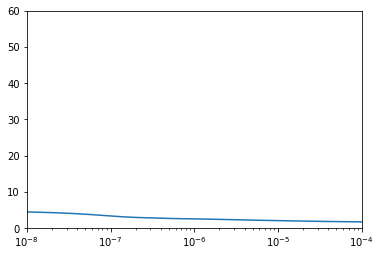

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 27)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=250)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/250
25/25 [==============================] - 13s 539ms/step - loss: 6.9960 - mae: 7.5477
Epoch 2/250
25/25 [==============================] - 6s 230ms/step - loss: 3.5229 - mae: 4.0129
Epoch 3/250
25/25 [==============================] - 6s 230ms/step - loss: 2.6880 - mae: 3.1548
Epoch 4/250
25/25 [==============================] - 6s 244ms/step - loss: 2.5964 - mae: 3.0568
Epoch 5/250
25/25 [==============================] - 6s 229ms/step - loss: 2.5151 - mae: 2.9815
Epoch 6/250
25/25 [==============================] - 6s 233ms/step - loss: 2.4596 - mae: 2.9230
Epoch 7/250
25/25 [==============================] - 6s 229ms/step - loss: 2.4044 - mae: 2.8696
Epoch 8/250
25/25 [==============================] - 6s 230ms/step - loss: 2.3553 - mae: 2.8207
Epoch 9/250
25/25 [==============================] - 6s 230ms/step - loss: 2.3069 - mae: 2.7726
Epoch 10/250
25/25 [==============================] - 6s 228ms/step - loss: 2.2675 - mae: 2.7279
Epoch 11/250
25/25 [==================

11/25 [============>.................] - ETA: 3s - loss: 1.8641 - mae: 2.3180

KeyboardInterrupt: 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.780626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]
